## Dog Classifying App

#### Made by Morgan Kidd
#### May 15, 2018
#### Based on coursework for the Udacity Machine Learning Engineer Nanodegree

* [Step 0](#step0): Data Processing
* [Step 1](#step1): Dog Breed Classification with Transfer Learning
* [Step 2](#step2): Detect Humans
* [Step 3](#step3): Detect Dogs
* [Step 4](#step4): Detection Algorithm
* [Step 5](#step5): Appending (Image Augmentation)

<a id='step0'></a>
### Data Processing:

We'll start by loading the dog images, and splitting the images in to training, validation and testing sets. These images were provided through the Udacity Machine Learning Engineer Nanodegree program, but another useful set could be from the (Oxford-IIIT Pet Database)[http://www.robots.ox.ac.uk/~vgg/data/pets/].

In [2]:
#Initiate a random seed for later
import random
random.seed(423)

In [3]:
from sklearn.datasets import load_files       
from keras.utils import np_utils
import numpy as np
from glob import glob

# define function to load train, test, and validation datasets
def load_dataset(path):
    data = load_files(path)
    dog_files = np.array(data['filenames'])
    dog_targets = np_utils.to_categorical(np.array(data['target']), 133)
    return dog_files, dog_targets

# load train, test, and validation datasets
train_files, train_targets = load_dataset('dogImages/train')
valid_files, valid_targets = load_dataset('dogImages/valid')
test_files, test_targets = load_dataset('dogImages/test')

# load list of dog names
dog_names = [item[20:-1] for item in sorted(glob("dogImages/train/*/"))]

# print statistics about the dataset
print('There are %d total dog categories.' % len(dog_names))
print('There are %s total dog images.\n' % len(np.hstack([train_files, valid_files, test_files])))
print('There are %d training dog images.' % len(train_files))
print('There are %d validation dog images.' % len(valid_files))
print('There are %d test dog images.'% len(test_files))

D:\Coding\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


There are 133 total dog categories.
There are 8351 total dog images.

There are 6680 training dog images.
There are 835 validation dog images.
There are 836 test dog images.


Transform data:

In [4]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

We'll convert the images to tensors for feeding in to the model. We'll also use the ImageFile package to deal with small (truncated) images, and then normalize the value of each pixel to [0,1].

In [5]:
from PIL import ImageFile                            
ImageFile.LOAD_TRUNCATED_IMAGES = True                 

train_tensors = paths_to_tensor(train_files).astype('float32')/255
valid_tensors = paths_to_tensor(valid_files).astype('float32')/255
test_tensors = paths_to_tensor(test_files).astype('float32')/255

100%|████████████████████████████████████████████████████████████████████████████████| 836/836 [00:09<00:00, 88.80it/s]


<a id='step1'></a>
### Transfer Learning Model

Before fitting a model, we should consider expanding the training and validation sets with image augmentation. The InceptionV3 model (next) performs very well even on just the base dataset, and I wasn't able to improve performance with augmentation, so this is optional. Just in case, I've included the code to fit the model with augmented images at the end of the notebook.

This is the main crux of the model, I'm going to use transfer learning to train a model adept at identifying breeds. The idea behind this is that there are a handful of very well trained, very large network models (e.g. Resnet, Inception, etc.) that are very good at classifying images. It is unlikely that I could train a better performing network on my own, so why not build upon the work of others? 

In this step, I'll import the InceptionV3 network, and then modify and train the last few classification layers to classify dog breeds. To do this, I will input each of the tensor sets through InceptionV3 and then output the intermediary "bottleneck feature" set, which can then be passed through a small number of pooling and dense layers to get our output.

Computing the bottleneck features is intense, and will likely take around 10-15 minutes on a CPU. I've saved and uploaded the model weights at the end of this code block, so this step may be skipped on repeat runs.

In [6]:
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from keras.layers import Dense, GlobalAveragePooling2D


InceptionV3_model = InceptionV3(weights='imagenet', include_top=False)


In [7]:
#Training - skip this step if you use the loaded weights
InceptionV3_output = InceptionV3_model.predict(train_tensors, batch_size=100, verbose=1)
InceptionV3_valid = InceptionV3_model.predict(valid_tensors, batch_size=100, verbose=1)
InceptionV3_test = InceptionV3_model.predict(test_tensors, batch_size=100, verbose=1)

836/836 [==============================] - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - ETA:  - 7s 9ms/step


In [8]:
np.shape(InceptionV3_output)
#save weights
np.save(arr=InceptionV3_output,file='InceptionV3.tensor_train')
np.save(arr=InceptionV3_valid, file='InceptionV3.tensor_valid')
np.save(arr=InceptionV3_test, file='InceptionV3.tensor_test')

In [9]:
from keras.models import Sequential
from keras.layers import Dropout

model = Sequential()
model.add(GlobalAveragePooling2D(input_shape=np.shape(InceptionV3_output)[1:4]))
model.add(Dropout(0.2))
model.add(Dense(133,activation='softmax'))

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
global_average_pooling2d_1 ( (None, 2048)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 2048)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 133)               272517    
Total params: 272,517
Trainable params: 272,517
Non-trainable params: 0
_________________________________________________________________


In [10]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
#More training - skip this if using loaded weights
from keras.callbacks import ModelCheckpoint  


epochs = 20
cp = ModelCheckpoint(filepath='saved_models/InceptionV3.weights.hdf5', 
                               verbose=1, save_best_only=True)

model.fit(InceptionV3_output, train_targets, 
          validation_data=(InceptionV3_valid, valid_targets),
          epochs=epochs, batch_size=100, callbacks=[cp], verbose=2)

Train on 6680 samples, validate on 835 samples
Epoch 1/20
 - 5s - loss: 1.6107 - acc: 0.6220 - val_loss: 0.6694 - val_acc: 0.8108

Epoch 00001: val_loss improved from inf to 0.66942, saving model to saved_models/InceptionV3.weights.hdf5
Epoch 2/20
 - 2s - loss: 0.5618 - acc: 0.8232 - val_loss: 0.6154 - val_acc: 0.8299

Epoch 00002: val_loss improved from 0.66942 to 0.61543, saving model to saved_models/InceptionV3.weights.hdf5
Epoch 3/20
 - 2s - loss: 0.3919 - acc: 0.8719 - val_loss: 0.5570 - val_acc: 0.8395

Epoch 00003: val_loss improved from 0.61543 to 0.55700, saving model to saved_models/InceptionV3.weights.hdf5
Epoch 4/20
 - 2s - loss: 0.3141 - acc: 0.8937 - val_loss: 0.5244 - val_acc: 0.8443

Epoch 00004: val_loss improved from 0.55700 to 0.52437, saving model to saved_models/InceptionV3.weights.hdf5
Epoch 5/20
 - 2s - loss: 0.2552 - acc: 0.9154 - val_loss: 0.5393 - val_acc: 0.8491

Epoch 00005: val_loss did not improve
Epoch 6/20
 - 2s - loss: 0.2050 - acc: 0.9331 - val_loss: 0

Load best fit model and then check test accuracy:

In [12]:
model.load_weights('saved_models/InceptionV3.weights.hdf5')

In [13]:
model_pred = [np.argmax(model.predict(np.expand_dims(feature, axis=0))) for feature in InceptionV3_test]
test_accuracy = 100*np.sum(np.array(model_pred)==np.argmax(test_targets, axis=1))/len(model_pred)
print('Test accuracy: %.4f%%' % test_accuracy)

Test accuracy: 80.9809%


With some tuning we may be able to achieve a slightly higher accuracy, but this is probably good enough for non-commercial purposes.

Now I'll Make a function to take an image, extract the InceptionV3 bottleneck features like above, and then run through our model to predict breed:

In [14]:
def InceptionV3_predict_breed(img_path):
    # extract features
    bottleneck_feature = InceptionV3_model.predict(path_to_tensor(img_path).astype('float32')/255)
    # prediction vector
    predicted_vector = model.predict(bottleneck_feature)
    # return prediction
    return dog_names[np.argmax(predicted_vector)]

Test example:

In [15]:
import cv2
import matplotlib.pyplot as plt  
cv_rgb = cv2.cvtColor(cv2.imread(test_files[2]), cv2.COLOR_BGR2RGB)
plt.imshow(cv_rgb)
plt.show()

In [16]:
print(InceptionV3_predict_breed(test_files[2]))
print(dog_names[np.argmax(test_targets[2])])

Papillon
Papillon


So this seems adequate, we'll return to this activity of predicting later.

<a id='step2'></a>
### Detect Humans

Finally, to round out the implementation kinks, we can make a rudimentary classifier to determine if an image is a dog, a human, or neither. 

In [17]:
#Import human faces from glob, shuffle because the faces are in alphabetical order
human_files = np.array(glob("lfw/*/*"))
random.shuffle(human_files)

print('There are %d total human images.' % len(human_files))

There are 13233 total human images.


For the human classifier, we'll try using the [Haar feature based classifier](http://opencv-python-tutroals.readthedocs.io/en/latest/py_tutorials/py_objdetect/py_face_detection/py_face_detection.html), see a demonstration below:

Number of faces detected: 1


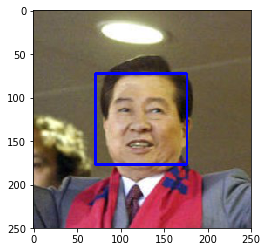

In [18]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline     


# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread(human_files[3])
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Now we can write a short function to detect if a face is human or not, and then test it's accuracy.

In [19]:
def face_detector(img_path):
    img = cv2.imread(img_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    faces = face_cascade.detectMultiScale(gray)
    return len(faces) > 0

In [20]:
human_files_short = human_files[:100]
dog_files_short = train_files[:100]

def detect(detector, files):
    return sum([1 if detector(f) else 0 for f in files]) / len(files)
print('Percent of human faces detected: {:.2f}%'.format(detect(face_detector, human_files_short) * 100))
print('Percentage of dogs detected as humans: {:.2f}%'.format(detect(face_detector, dog_files_short) * 100))


Percent of human faces detected: 98.00%
Percentage of dogs detected as humans: 12.00%


The Cascade classifier catches almost all of the humans and has a relatively small portion of misclassified dogs. Obviously, not all non-humans are dogs, so we'll need to make a dog identifying algorithm as well.

<a id='step3'></a>
### Detect Dogs


To do this, we'll use the Resnet-50 network. This model is already pre-trained, so we only need to input an image and then return if the predicted label is a dog or not. Finally, we can wrap this up in a function to easily return if the target is a dog or not.

In [21]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')


In [22]:
from keras.applications.resnet50 import preprocess_input, decode_predictions

def ResNet50_predict_labels(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(path_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

In [23]:
def dog_detector(img_path):
    prediction = ResNet50_predict_labels(img_path)
    return ((prediction <= 268) & (prediction >= 151)) 

In [24]:
print('Percentage of human faces detected as dogs: {:.2f}%'.format(detect(dog_detector, human_files_short) * 100))
print('Percentage of dogs detected: {:.2f}%'.format(detect(dog_detector, dog_files_short) * 100))

Percentage of human faces detected as dogs: 2.00%
Percentage of dogs detected: 100.00%


Once again, this function accurately predicts all the dogs and has a low misclassification rate.

<a id='step4'></a>
### Classification Algorithm

Finally, we can put all these components in to one composite function that takes an image and returns a dog breed prediction if the subject is a human or a dog. I've also included a small codeblock that will return an image of the selected breed for reference.

In [25]:
def dog_app(img_path):
    isdog = dog_detector(img_path)
    ishuman = face_detector(img_path)
    
    cv_rgb = cv2.cvtColor(cv2.imread(img_path), cv2.COLOR_BGR2RGB)
    plt.imshow(cv_rgb)
    plt.show()
    
    #Dog Case
    if(isdog==True and ishuman==False):
        print("This is a dog")
        print("I'm trying to guess the breed, one moment...")
        pred = InceptionV3_predict_breed(img_path)
        print("This looks like a ", pred, "!")
        
        #Return image of predicted breed:
        index = dog_names.index(pred)
        dog_index = np.where(train_targets[:,index].flatten() == 1.0)
        cv_rgb = cv2.cvtColor(cv2.imread(train_files[random.choice(dog_index[0])]), cv2.COLOR_BGR2RGB)
        plt.imshow(cv_rgb)
        plt.show()
        
    #Human Case
    if(isdog==False and ishuman==True):
        print("This is a human")
        print("I'm thinking about what breed you most resemble, one moment...")
        pred = InceptionV3_predict_breed(img_path)
        print("You look like a ", pred, "!")
        
        #Return image of predicted breed:
        index = dog_names.index(pred)
        dog_index = np.where(train_targets[:,index].flatten() == 1.0)
        cv_rgb = cv2.cvtColor(cv2.imread(train_files[random.choice(dog_index[0])]), cv2.COLOR_BGR2RGB)
        plt.imshow(cv_rgb)
        plt.show()
        
    #False Positive Case
    if(isdog==True and ishuman==True):
        print("Error: Cannot determine if image is dog or human, too dog-like! Try again with a different photo.")
    #Neither Case
    if(isdog==False and ishuman==False):
        print("Error: This isn't a dog or a human! Please try again with a different photo.")
    
    return None

See some test samples below. The results for human classification is a bit silly, but would we really expect any different from a function like this?

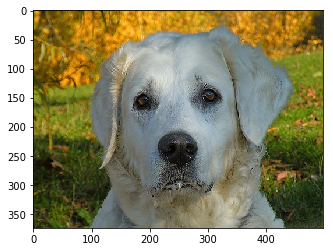

This is a dog
I'm trying to guess the breed, one moment...
This looks like a  Kuvasz !


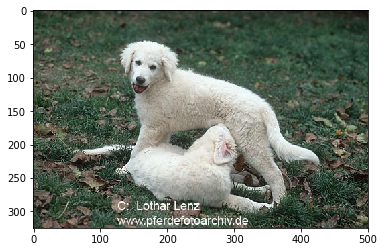

In [26]:
dog_app(test_files[23])

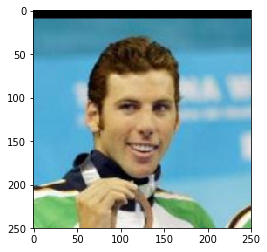

This is a human
I'm thinking about what breed you most resemble, one moment...
You look like a  Dachshund !


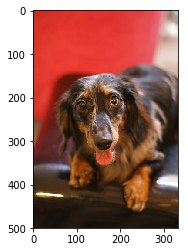

In [27]:
dog_app(human_files[51])

<a id='step5'></a>
### APPENDIX:

As mentioned above, we can also include image augmentation to increase the robustness of our model. Though this is generally a good idea, pre-trained models tend to be sufficiently well trained as to not require the augmented images, and so augmentation only benefits our final classification layers. 

Using augmentation also requires a slightly more compact model assembly, where we it is tricky to seperately compute the bottleneck features. This can be problematic when we wish to tune the final classification layers, since we'd need to re-predict the bottleneck features through the InceptionV3 net every time we change a specification.

Finally, image augmentation is very computationally intensive when fitting a model (since we're duplicating the data), and run-time will increase proportionally to the batch_size parameter in the datagen flow method.

In [ ]:
from keras.preprocessing.image import ImageDataGenerator

# create and configure augmented image generator
datagen_train = ImageDataGenerator(
    width_shift_range=0.2,  # randomly shift images horizontally (20% of total width)
    height_shift_range=0.2,  # randomly shift images vertically (20% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# create and configure augmented image generator
datagen_valid = ImageDataGenerator(
    width_shift_range=0.2,  # randomly shift images horizontally (20% of total width)
    height_shift_range=0.2,  # randomly shift images vertically (20% of total height)
    horizontal_flip=True) # randomly flip images horizontally

# fit augmented image generator on data
datagen_train.fit(train_tensors)
datagen_valid.fit(valid_tensors)

In [ ]:
# Alternate model specification

from keras.applications.inception_v3 import InceptionV3
from keras.models import Model, Sequential
from keras.layers import Dense, GlobalAveragePooling2D, Dropout

base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=np.shape(train_tensors)[1:4])
model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D(input_shape=np.shape(InceptionV3_output)[1:4]))
model.add(Dropout(0.2))
model.add(Dense(133,activation='softmax'))


##Toggle the InceptionV3 layers as un-trainable:
for layer in base_model.layers:
    layer.trainable = False
    
model.summary()

In [ ]:
model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
#More training - skip this if using loaded weights
from keras.callbacks import ModelCheckpoint  

batch_size=100
epochs = 20
cp = ModelCheckpoint(filepath='saved_models/InceptionV3.augmented.weights.hdf5', 
                               verbose=1, save_best_only=True)

#model.fit(InceptionV3_output, train_targets, 
#          validation_data=(InceptionV3_valid, valid_targets),
#          epochs=epochs, batch_size=100, callbacks=[cp], verbose=2)

model.fit_generator(datagen_train.flow(train_tensors, train_targets, batch_size=32),
                    steps_per_epoch=train_tensors.shape[0] // batch_size,
                    epochs=epochs, verbose=2, callbacks=[cp],
                    validation_data=datagen_valid.flow(valid_tensors, valid_targets, batch_size=32),
                    validation_steps=valid_tensors.shape[0] // batch_size)